# Neural Networks

We will use a neural network for creating a model which be able to classify correctly.
As the dataset is small, 400 instances, we will follow a straight-line approach:
- We will use a shallow networks because deep ones need more examples.
- We will use **L2 Regularization (Weight Decay)** and **Early Stopping** to stop training the moment the model stops improving
- A small preprocessing, so neural networks require scaling to converge

# Using dataset with null values imputed


## Starting point

In [1]:
from pathlib import Path
import pandas as pd


dataset_imputed_path = Path('../../data/processed/dataset_imputed.csv')
df_orig = pd.read_csv(dataset_imputed_path)
df = df_orig.copy()
df['status'] = df['status'].map({'ckd': 1, 'notckd': 0})

df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,status
0,48.0,80.0,3,1,0.0,1.0,0.0,0.0,0.0,121.000000,...,44.0,7800.0,5.200000,1.0,1.0,0.0,0.0,0.0,0,1
1,7.0,50.0,3,4,0.0,0.0,0.0,0.0,0.0,94.708381,...,38.0,6000.0,4.277045,0.0,0.0,0.0,0.0,0.0,0,1
2,62.0,80.0,1,2,3.0,0.0,0.0,0.0,0.0,423.000000,...,31.0,7500.0,3.725814,0.0,1.0,0.0,1.0,0.0,1,1
3,48.0,70.0,0,4,0.0,0.0,1.0,1.0,0.0,117.000000,...,32.0,6700.0,3.900000,1.0,0.0,0.0,1.0,1.0,1,1
4,51.0,80.0,1,2,0.0,0.0,0.0,0.0,0.0,106.000000,...,35.0,7300.0,4.600000,0.0,0.0,0.0,0.0,0.0,0,1


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Calculate correlation matrix
corr_matrix = df.corr()

# Plot heatmap
#plt.figure(figsize=(20, 15))
#sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
#plt.title('Feature Correlation Matrix')
#plt.show()

# Quick check for high correlation
correlation_factor = 0.8
high_corr_pairs = np.where(np.abs(corr_matrix) > correlation_factor)
high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y])
                   for x, y in zip(*high_corr_pairs) if x != y and x < y]

print("Highly correlated pairs to consider dropping:", high_corr_pairs)


Highly correlated pairs to consider dropping: [('bu', 'sc'), ('hemo', 'pcv'), ('hemo', 'rbcc'), ('pcv', 'rbcc')]


Removing dependant features
----

We identified two distinct biological clusters of redundancy.
The first one is the **red blood cell cluster**. With pairs: ('hemo', 'pcv'), ('hemo', 'rbcc'), ('pcv', 'rbcc') as we know:
- Hemo (Hemoglobin): The protein that carries oxygen.
- PCV (Packed Cell Volume): The percentage of blood volume made up of cells.
- RBCC (Red Blood Cell Count): The actual number of cells.

Also, it is important to note that healthy patients PCV = hemo * 3.
So we will keep hemoglobin as it is typically the most robust measurement and is the standard metric for diagnosing anemia in CKD patients.


The second one is the **kideny waste cluster**. With pair: ('bu', 'sc') as we know:
Both Blood Urea (bu) and Serum Creatinine (sc) are waste products filtered by the kidneys. As kidney function declines (CKD progresses), both of these numbers rise together.
In this case, we will keep sc as it is a good marker to calculate the glomerular filtration rate [1] and stage Kidney Disease.

[1] https://en.wikipedia.org/wiki/Glomerular_filtration_rate


In [3]:
cols_to_drop = ['pcv', 'rbcc', 'bu']

existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]

df.drop(columns=existing_cols_to_drop, inplace=True)

print(f"Dropped columns: {existing_cols_to_drop}")
print(f"Remaining columns: {df.shape[1]}")

Dropped columns: ['pcv', 'rbcc', 'bu']
Remaining columns: 22


Normalization
----

We will apply a **standarization** of the numerical/continuous features. For the binary and categorical features (0/1) we could:
- Leave them as 0/1 or
- Scale them too.

In our case, we will scale everything.



In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop('status', axis=1)
y = df['status']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Mean of scaled features (approx 0):")
print(X_train_scaled.mean().head())

print("\nStandard Deviation of scaled features (approx 1):")
print(X_train_scaled.std().head())

Mean of scaled features (approx 0):
age    1.609823e-16
bp    -2.595146e-16
sg    -9.992007e-17
al    -2.359224e-17
su    -8.326673e-18
dtype: float64

Standard Deviation of scaled features (approx 1):
age    1.001566
bp     1.001566
sg     1.001566
al     1.001566
su     1.001566
dtype: float64


## Data preprocessing


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1) # Shape becomes (N, 1)

X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)


# Create DataLoaders
# Batch size implies how many patients the model sees before updating weights
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training on {len(train_dataset)} samples. Testing on {len(test_dataset)} samples.")


Training on 320 samples. Testing on 80 samples.


Neurol Network Architecture
----

We will define the model. We will include Droput layers. This is crucial for medical data because it randomly turns off neurons during training, forcing the model to learn robust features rather than memorizing specific patient cases (overfitting)


In [9]:
class CKDClassifier(nn.Module):
    def __init__(self, input_dim):
        super(CKDClassifier, self).__init__()

        # Layer 1: Input -> Hidden
        self.layer1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3) # Drop 30%of connections to prevent overfitting

        # Layer 2: Hidden -> Hidden
        self.layer2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        # Layer 3: Hidden -> Output
        # Output is 1 neuron because it's binary classification
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.dropout1(x)
        x = self.relu2(self.layer2(x))
        x = self.dropout2(x)
        output = self.output(x)

        return output

# Initialize the model
input_features = X_train_tensor.shape[1]
model = CKDClassifier(input_features)
print(model)


CKDClassifier(
  (layer1): Linear(in_features=21, out_features=64, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Training loop
 -----
 We will use `BCEWithLogitsLoss`. This combines a **sigmoid** layer and the **binary cross entropy** loss into one single class. This is numerically more stable than applying a plain sigmoid.


In [10]:
# Hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 50

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
train_losses = []

for epoch in range(EPOCHS):
    model.train() # Set model to training mode (enables Dropout)
    running_loss = 0.0

    for inputs, labels in train_loader:
        # 1. Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 2. Backward pass and optimization
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()       # Calculate new gradients
        optimizer.step()      # Update weights

        running_loss += loss.item()

    # Calculate average loss for this epoch
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}')

print("Training Complete!")


Epoch [10/50], Loss: 0.1166
Epoch [20/50], Loss: 0.0262
Epoch [30/50], Loss: 0.0240
Epoch [40/50], Loss: 0.0108
Epoch [50/50], Loss: 0.0062
Training Complete!


Evaluation
----


Test Accuracy: 1.0000


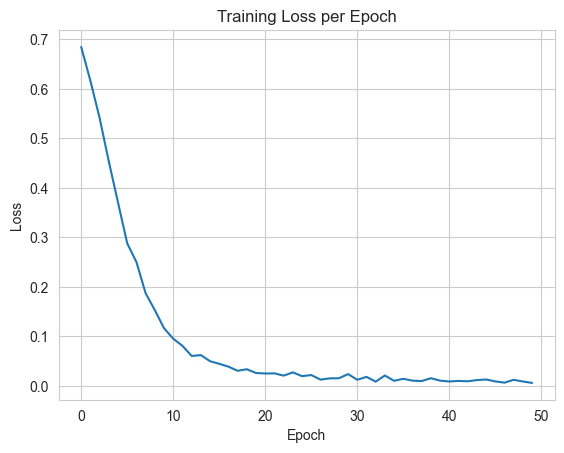

In [11]:
# Evaluation
model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculation for speed
    y_pred_logits = model(X_test_tensor)
    y_pred_probs = torch.sigmoid(y_pred_logits) # Apply sigmoid to get probability 0-1
    y_pred_class = (y_pred_probs > 0.5).float() # Convert probability to 0 or 1 class

    # Calculate Accuracy
    accuracy = (y_pred_class == y_test_tensor).sum() / y_test_tensor.shape[0]
    print(f"Test Accuracy: {accuracy.item():.4f}")

# Optional: Plot Loss Curve to check for convergence
plt.plot(train_losses)
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = y_test_tensor.cpu().numpy()
y_pred = y_pred_class.cpu().numpy()

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
f1_score = (2*sensitivity*precision)/(precision + sensitivity)

print(f"--- Clinical Performance Metrics ---")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity:          {specificity:.4f}")
print(f"Precision:            {precision:.4f}")
print(f"F1-Score:            {f1_score:.4f}")
print("-" * 30)

--- Clinical Performance Metrics ---
Sensitivity (Recall): 1.0000
Specificity:          1.0000
Precision:            1.0000
F1-Score:            1.0000
------------------------------



Detailed Report:
              precision    recall  f1-score   support

     Not CKD       1.00      1.00      1.00        30
         CKD       1.00      1.00      1.00        50

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



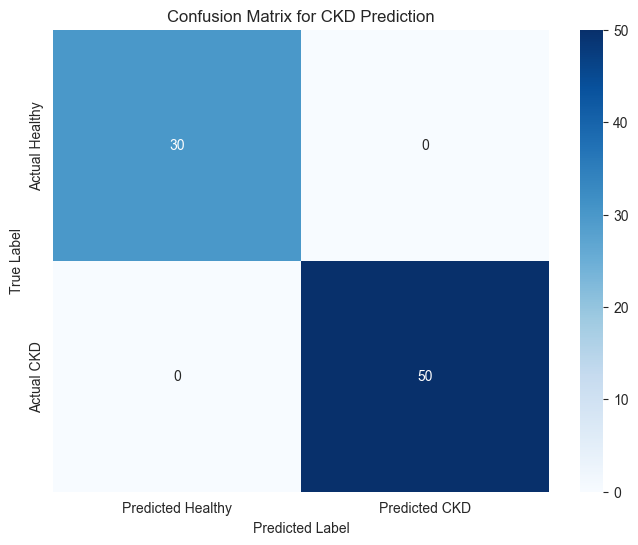

In [13]:
print("\nDetailed Report:")
print(classification_report(y_true, y_pred, target_names=['Not CKD', 'CKD']))

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Healthy', 'Predicted CKD'],
            yticklabels=['Actual Healthy', 'Actual CKD'])
plt.title('Confusion Matrix for CKD Prediction')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Robust validation using k-fold
----

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Combine data back for K-Fold (since we need to reshuffle it manually)
X_full = np.concatenate((X_train_scaled.values, X_test_scaled.values), axis=0)
y_full = np.concatenate((y_train.values, y_test.values), axis=0)

# Define K-Fold
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=33)

# Dictionary to store results for all metrics
metrics_history = {
    'accuracy': [],
    'precision': [],
    'sensitivity': [], # Same as Recall
    'specificity': [],
    'f1': []
}

print(f"Starting {k_folds}-Fold Cross-Validation...")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_full, y_full)):
    # Slice data
    X_train_fold = torch.tensor(X_full[train_idx], dtype=torch.float32)
    y_train_fold = torch.tensor(y_full[train_idx], dtype=torch.float32).unsqueeze(1)
    X_val_fold = torch.tensor(X_full[val_idx], dtype=torch.float32)
    y_val_fold = torch.tensor(y_full[val_idx], dtype=torch.float32).unsqueeze(1)

    # Re-initialize model completely for each fold
    model_fold = CKDClassifier(input_dim=X_full.shape[1])
    optimizer = optim.Adam(model_fold.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()

    # Quick Training Loop (50 epochs)
    model_fold.train()
    for epoch in range(50):
        optimizer.zero_grad()
        outputs = model_fold(X_train_fold)
        loss = criterion(outputs, y_train_fold)
        loss.backward()
        optimizer.step()

    # Evaluation
    model_fold.eval()
    with torch.no_grad():
        logits = model_fold(X_val_fold)
        # Convert to binary predictions (0 or 1)
        preds = (torch.sigmoid(logits) > 0.5).float()

        # Move to CPU/Numpy for Scikit-Learn metrics
        y_true_np = y_val_fold.cpu().numpy()
        y_pred_np = preds.cpu().numpy()

        # 1. Calculate Standard Metrics
        acc = (preds == y_val_fold).sum() / y_val_fold.shape[0]
        prec = precision_score(y_true_np, y_pred_np, zero_division=0)
        rec = recall_score(y_true_np, y_pred_np, zero_division=0) # Sensitivity
        f1 = f1_score(y_true_np, y_pred_np, zero_division=0)

        # 2. Calculate Specificity manually from Confusion Matrix
        # TN = True Negative, FP = False Positive
        tn, fp, fn, tp = confusion_matrix(y_true_np, y_pred_np).ravel()
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

        # Store results
        metrics_history['accuracy'].append(acc.item())
        metrics_history['precision'].append(prec)
        metrics_history['sensitivity'].append(rec)
        metrics_history['specificity'].append(spec)
        metrics_history['f1'].append(f1)

        print(f"Fold {fold+1}: Acc={acc.item():.4f} | Sens={rec:.4f} | Spec={spec:.4f} | F1={f1:.4f}")

# Final Averages
print("\n" + "="*40)
print("FINAL CROSS-VALIDATION RESULTS (Mean ± Std)")
print("="*40)
for metric, values in metrics_history.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric.capitalize():<12}: {mean_val:.4f} ± {std_val:.4f}")

Starting 5-Fold Cross-Validation...
Fold 1: Acc=0.9375 | Sens=0.9000 | Spec=1.0000 | F1=0.9474
Fold 2: Acc=0.9500 | Sens=0.9200 | Spec=1.0000 | F1=0.9583
Fold 3: Acc=0.9750 | Sens=0.9600 | Spec=1.0000 | F1=0.9796
Fold 4: Acc=0.9500 | Sens=0.9200 | Spec=1.0000 | F1=0.9583
Fold 5: Acc=0.9750 | Sens=0.9600 | Spec=1.0000 | F1=0.9796

FINAL CROSS-VALIDATION RESULTS (Mean ± Std)
Accuracy    : 0.9575 ± 0.0150
Precision   : 1.0000 ± 0.0000
Sensitivity : 0.9320 ± 0.0240
Specificity : 1.0000 ± 0.0000
F1          : 0.9646 ± 0.0128


Saving the model for deployment
----
In Pytorch, we need to save the state dictionary, not the entire architecture.


In [15]:
# Retrain on the FULL dataset (X_full, y_full)
# We want the final model to have seen as much data as possible before deployment.
final_model = CKDClassifier(input_dim=X_full.shape[1])
optimizer = optim.Adam(final_model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

# Convert numpy full data to tensors
X_full_tensor = torch.tensor(X_full, dtype=torch.float32)
y_full_tensor = torch.tensor(y_full, dtype=torch.float32).unsqueeze(1)

# Train on all data
final_model.train()
for epoch in range(50):
    optimizer.zero_grad()
    outputs = final_model(X_full_tensor)
    loss = criterion(outputs, y_full_tensor)
    loss.backward()
    optimizer.step()

print("Final model training complete.")

# 2. Save the Model Weights
model_path = Path('../../models/ckd_classifier_data_imputed.pth')
torch.save(final_model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")

# ---------------------------------------------------------
# HOW TO LOAD IT LATER (e.g., in a web app or different script)
# ---------------------------------------------------------
# loaded_model = CKDClassifier(input_dim=14) # Initialize the same architecture
# loaded_model.load_state_dict(torch.load(model_path))
# loaded_model.eval() # Set to eval mode for prediction
# print("Model loaded successfully!")

Final model training complete.
Model weights saved to ..\..\models\ckd_classifier_data_imputed.pth
